In [16]:
!pip install plotly

You should consider upgrading via the '/home/victor/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
death_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
deaths_df = pd.read_csv(death_url, error_bad_lines=False)

cases_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
cases_df = pd.read_csv(cases_url, error_bad_lines=False)

states_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-08-2020.csv"
states_df = pd.read_csv(states_url, error_bad_lines=False)

# county_level = "https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv"
county_df = pd.read_csv('./covid19/small_abridged.csv', error_bad_lines=False)

In [3]:
deaths_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,97,97,99,99,102,107,108,111,113,114
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,4,4,4,4,4,4,4,4,5,6


# Data Cleaning

In [4]:
#drop territories
cases = cases_df[~cases_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
cases = cases[~cases['FIPS'].isnull()] 
#change FIPS to integer type
cases['FIPS'] = cases['FIPS'].astype(int)
#Only dealing with states, so county is better name
cases = cases.rename(columns={'Admin2':'County'}) 
#the country is US, unnecessary
cases = cases.drop(columns=['Country_Region'])
cases.head()

#repeat for deaths

#drop territories
deaths = deaths_df[~deaths_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
deaths = deaths[~deaths['FIPS'].isnull()] 
#change FIPS to integer type
deaths['FIPS'] = deaths['FIPS'].astype(int)
#Only dealing with states, so county is better name
deaths = deaths.rename(columns={'Admin2':'County'})
deaths.head()

county = county_df.rename(columns={'countyFIPS':'FIPS', 'CountyName':'County'}).drop(columns=['Unnamed: 0'])
# drop rows that are not counties. There's only two: NYC and Kansas City, so shouldn't matter much
county = county[county['FIPS'].str.isnumeric()]
county['FIPS'] = county['FIPS'].astype(int)
county.head()

county_cases_deaths = pd.read_csv('county_info_cases_deaths.csv')
county_cases_deaths.head()


,Unnamed: 0,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,...,4/30/20_cases,5/1/20_cases,5/2/20_cases,5/3/20_cases,5/4/20_cases,5/5/20_cases,5/6/20_cases,5/7/20_cases,5/8/20_cases,5/9/20_cases
0,0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,...,44,42,45,48,53,53,58,61,67,68
1,1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,...,174,175,181,187,188,189,196,205,208,216
2,2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,...,39,42,43,45,45,47,47,51,53,58
3,3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,...,42,42,42,43,42,43,43,44,44,45
4,4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,...,37,39,40,40,40,40,42,44,44,44


In [5]:
def create_state_cases_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_cases = cases[cases['Province_State'] == state]
    state_cases = state_counties.merge(state_cases, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_cases[~state_cases['County_x'].isna()]

def create_state_deaths_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_deaths = deaths[deaths['Province_State'] == state]
    state_deaths = state_counties.merge(state_deaths, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_deaths[~state_deaths['County_x'].isna()]

california_cases = create_state_cases_with_county_data('California')
california_deaths = create_state_deaths_with_county_data('California')

In [7]:
california_cases_days = california_cases[california_cases.columns[-109:]]
# california_cases_days['peak cases'] = california_cases_days.max(axis=1)
# california_cases_days['peak infection rate'] = 
# california_cases_days.diff(axis=1)

# Exploratory Data Analysis
### Finding promising factors that are related to COVID-19 cases or fatalities

In [8]:
def date_columns(df, not_date_columns=False):
    """returns list of column names if they don't match regex for a date (filters out time series)"""
    columns = df.columns.str.contains(r'\d\/[\d]{1,2}\/\d\d')
    if not_date_columns:
        return [x for x in (~columns)*df.columns.values if x]

    return [x for x in columns*df.columns.values if x]
def find_correlations(df, correlate_with, columns_to_avoid='Default', highest_n=15):
    #Following columns are mostly population (and repeat info), must be normalized before correlating
    if columns_to_avoid == 'Default':
        columns_to_avoid = ['PopMale<52010', 'PopFmle<52010',
               'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
               'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
               'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
               'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
               'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
               'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
               'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
               'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
               'PopMale>842010', 'PopFmle>842010',  'PopTotalMale2017',
                'PopTotalFemale2017','3-YrMortalityAge<1Year2015-17',
                '3-YrMortalityAge1-4Years2015-17',
                '3-YrMortalityAge5-14Years2015-17',
                '3-YrMortalityAge15-24Years2015-17',
                '3-YrMortalityAge25-34Years2015-17',
                '3-YrMortalityAge35-44Years2015-17',
                '3-YrMortalityAge45-54Years2015-17',
                '3-YrMortalityAge55-64Years2015-17',
                '3-YrMortalityAge65-74Years2015-17',
                '3-YrMortalityAge75-84Years2015-17',
                '3-YrMortalityAge85+Years2015-17',  'Poverty Num All Ages 2018',
                'Poverty Num Ages 0-17 2018',
                'Poverty Num Ages 5-17 2018',
                'mortality2015-17Estimated',
                '3-YrDiabetes2015-17', 
                "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', 
                '#Hospitals', '#ICU_beds', 'MedicareEnrollment,AgedTot2017',
                'HPSAUnderservedPop', 'HPSAUnderservedPop.1', 'HPSAServedPop',
                'HPSAPercentPoverty', 'StrokeMortality', 'lon', 'Long_', 'lat', 'Lat',
                '#EligibleforMedicare2018', '#FTEHospitalTotal2017', 'PopulationEstimate65+2017',
                'Population', 'CensusPopulation2010']
    # ignore the dates as well
    columns_to_avoid += date_columns(df)
    # only correlate with quantitative variables
    numerics = df.select_dtypes(include=[np.number])
    corr, log_normal_corr, log_log_corr, normal_log_corr = [], [], [], []
    correlate_with_logged = np.log(correlate_with)
    # loop through all columns, calculating correlations
    for col in numerics:
        column = df[col]
        if col in columns_to_avoid or np.mean(column.isna()) > 0.5: # skip if to_avoid or is mostly nan
            continue
        corr.append((col, column.corr(correlate_with)))
        log_normal_corr.append((col, np.log(column).corr(correlate_with)))
        log_log_corr.append((col, np.log(column).corr(correlate_with_logged)))
        normal_log_corr.append((col, column.corr(correlate_with_logged)))
        
    def highest_n_columns(corrs):
        """ Return list of length highest_n, of tuples containing column name, correlation,
        sorted descending by abs(correlation)"""
        return sorted([x for x in corrs if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:highest_n]
    corr = highest_n_columns(corr)
    log_normal_corr = highest_n_columns(log_normal_corr)
    log_log_corr = highest_n_columns(log_log_corr)
    normal_log_corr = highest_n_columns(normal_log_corr)
    return corr, log_normal_corr, log_log_corr, normal_log_corr

In [38]:
def plot_correlations(df, corrs, corr_with, title):
    """create scatter plot between corrs columns and corr_with column, with line of best fit"""
    fig, axes = plt.subplots((len(corrs) + 2)//3, 3, figsize=(15, 17))
    for i in range(len(corrs)):
        col = corrs[i][0]
        ax = axes[i//3][i%3]
        x=df[col]
        y=corr_with
        sns.regplot(x=x,
                    y=y,
                    ax=ax,
                    fit_reg=True
                   )
        ax.set_title("Correlation: {}".format(x.corr(y).round(3)))
        ax.set_ylim(bottom=np.min(y) - np.std(y)/2, top=np.max(y) + np.std(y)/2)
        ax.set_xlim(left=np.min(x) - np.std(x)/2, right=np.max(x) + np.std(x)/2)
        ax.set_ylabel('County Coronavirus Cases per Capita')
        ax.set_xlabel(col, fontsize=18)

    fig.suptitle(title, fontsize=25)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

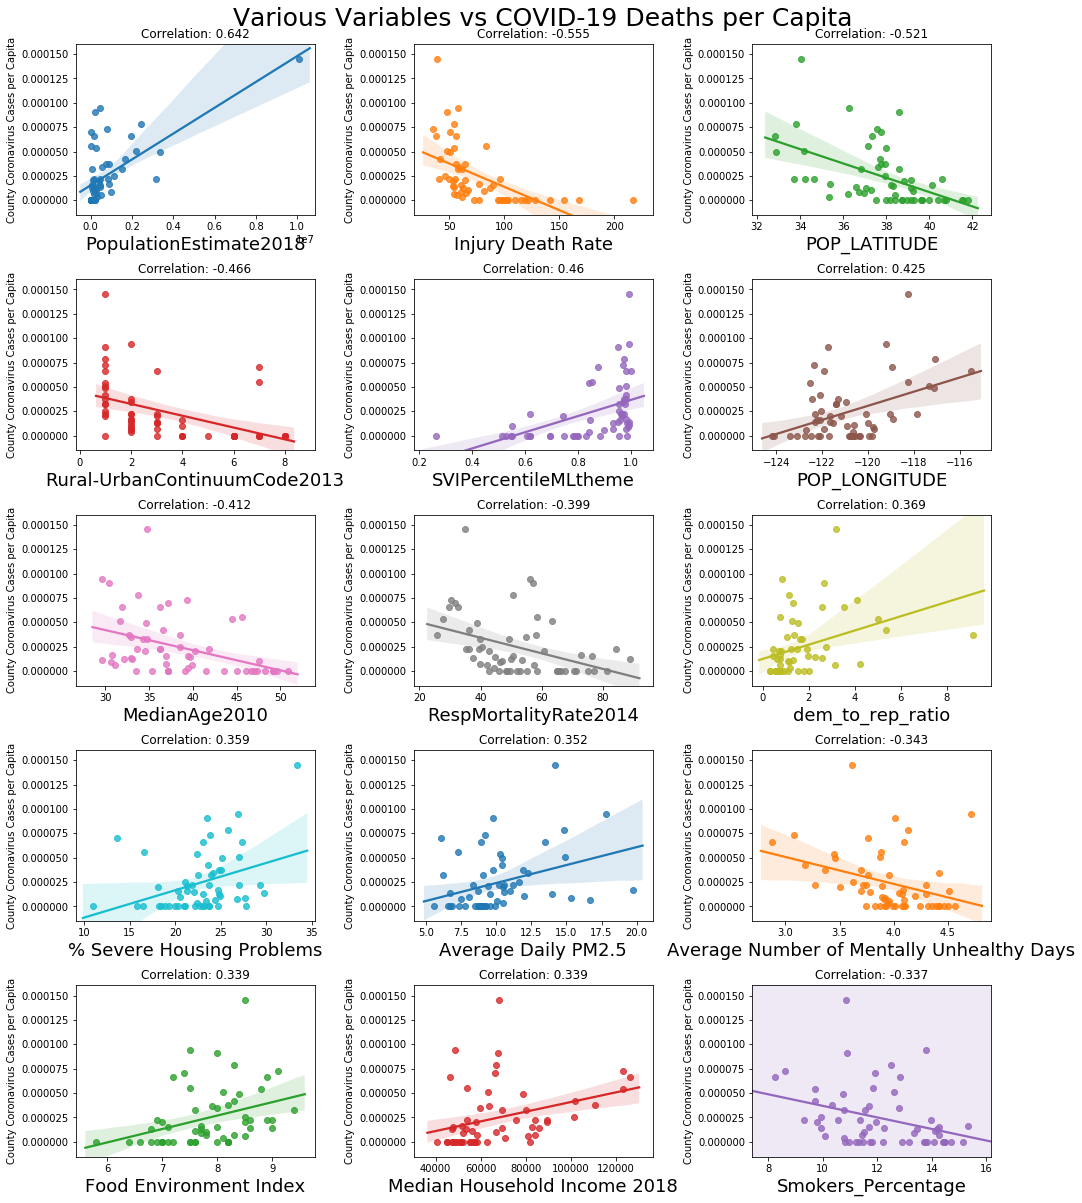

In [39]:
#Death Correlations
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_deaths, california_deaths['5/8/20']/california_deaths['PopulationEstimate2018'])
plot_correlations(california_deaths, corr, california_deaths['5/8/20']/california_deaths['PopulationEstimate2018'], title="Various Variables vs COVID-19 Deaths per Capita")

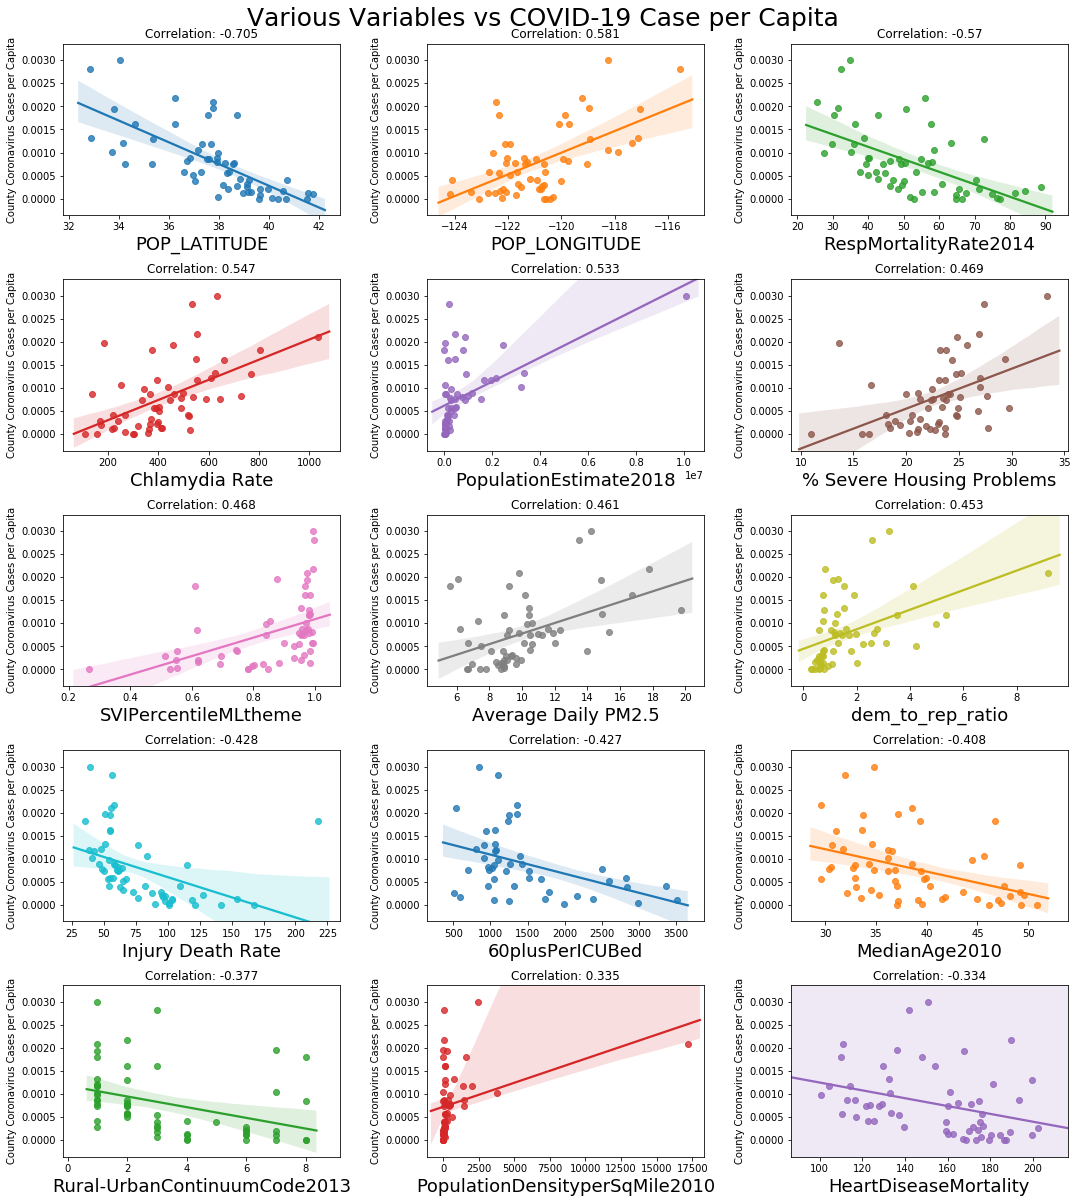

In [40]:
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_cases, california_cases['5/8/20']/california_cases['PopulationEstimate2018'])
plot_correlations(california_cases, corr, california_cases['5/8/20']/california_cases['PopulationEstimate2018'], title="Various Variables vs COVID-19 Case per Capita")

In [41]:
hundred_plus_infections = california_cases[california_cases['5/12/20'] > 100]
dates = date_columns(hundred_plus_infections)
infections_rate_smoothed = hundred_plus_infections[dates].diff(axis=1).rolling(5, axis=1).mean()
new_cases_last_14_days = hundred_plus_infections[dates].iloc[:,14:] - hundred_plus_infections[dates].iloc[:,:-14].values
doubling_days = (new_cases_last_14_days/infections_rate_smoothed.iloc[:,14:]).iloc[:,-30:]
# infections_rate_smoothed.iloc[:,-30:]
# california_cases[hundred_plus_infections['5/12/20'] > 100]
doubling_days

,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
0,14.135514,13.434579,16.439394,16.119403,14.220183,14.845133,10.833333,13.209607,12.970085,15.865922,...,13.541667,14.014423,13.786408,13.678414,13.388626,13.160377,11.821862,11.647059,12.626050,13.888889
6,20.277778,25.000000,17.596154,18.861386,15.642202,14.210526,10.886525,15.760870,13.008475,13.086957,...,12.233010,14.117647,14.102564,14.230769,17.615385,16.521739,12.977528,14.620253,18.095238,16.716418
9,14.363636,12.803030,11.730769,12.364865,10.691489,9.590909,11.397849,16.171875,13.197674,14.802632,...,11.777778,16.736842,11.977612,12.530864,11.049383,10.277778,9.567308,10.023474,14.494048,11.739130
12,22.142857,13.400000,10.394737,8.750000,8.125000,7.352941,8.909091,11.046512,11.145833,11.730769,...,13.716216,21.224490,13.888889,13.023256,11.494845,8.474026,9.062500,11.651786,9.758621,10.777027
14,11.393939,11.918239,10.790816,10.902062,11.126374,11.494253,12.204969,18.363636,19.764151,19.619048,...,12.088608,12.433333,12.302632,14.552239,13.231707,13.385093,11.155660,10.645933,10.751174,12.814208
15,8.000000,11.250000,9.000000,10.000000,8.125000,7.500000,7.187500,7.352941,7.105263,9.642857,...,7.471264,7.634409,8.137255,9.136364,11.379310,11.453488,11.720430,14.480519,14.651163,14.418605
18,18.567236,16.797323,16.873192,14.179509,13.635275,14.327666,13.918919,11.261343,9.556874,8.805231,...,14.201573,16.580214,13.738085,13.874631,12.967295,12.742424,12.069378,15.691751,16.453585,16.506757
20,22.187500,16.904762,18.823529,12.666667,10.147059,12.173913,13.684211,11.250000,18.666667,20.000000,...,15.937500,16.071429,35.000000,23.500000,23.750000,14.333333,13.235294,10.000000,11.388889,9.791667
23,9.032258,9.411765,13.750000,16.750000,19.411765,16.666667,19.687500,21.785714,24.230769,26.818182,...,10.416667,10.600000,12.500000,16.388889,18.333333,16.176471,15.250000,18.750000,15.476190,13.863636
26,11.086957,13.055556,10.000000,10.344828,8.918919,9.687500,7.551020,9.634146,10.750000,13.870968,...,9.900000,10.681818,14.354839,16.250000,18.600000,27.000000,15.312500,11.428571,12.631579,10.961538


/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


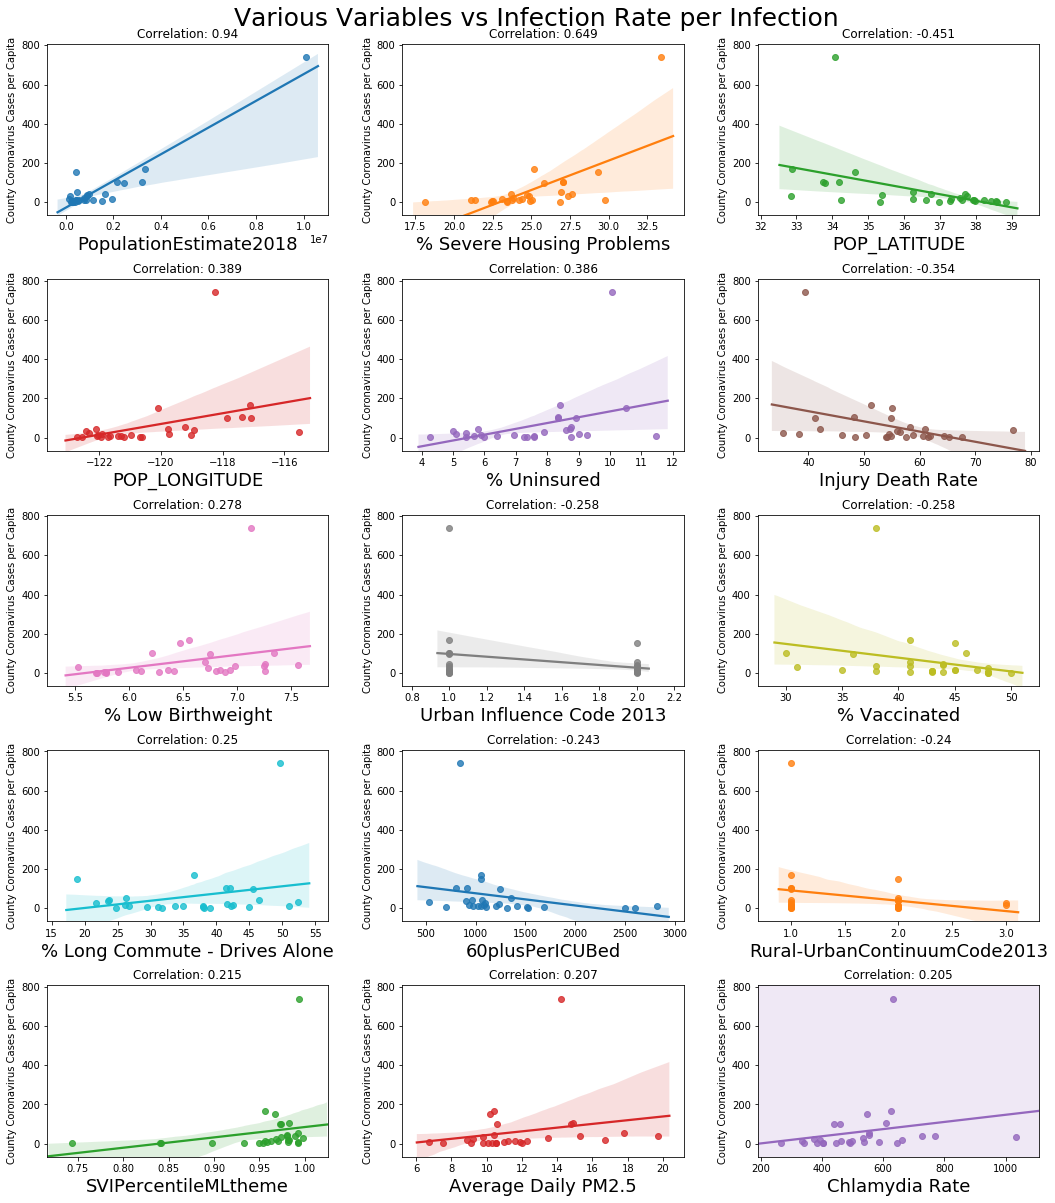

In [42]:
cases_doubling_rate  = infections_rate_smoothed['5/12/20']
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(hundred_plus_infections, cases_doubling_rate)
plot_correlations(hundred_plus_infections, corr, cases_doubling_rate, title="Various Variables vs Infection Rate per Infection")

# PCA
Run PCA on just the cases for a particular state.

In [63]:
dates = date_columns(california_cases)

#take just the cases, and normalize by population
ca = california_cases[dates].div(california_cases['PopulationEstimate2018'], axis=0)
#center and standardize the variance
ca = ((ca - ca.mean())/np.std(ca)).drop(columns=['1/22/20', '1/23/20', '1/24/20', '1/25/20'])
#PCA!
u, s, vt = np.linalg.svd(ca, full_matrices=False)
#Put the first 10 PC into a dataframe
pc_df = pd.DataFrame((u @ np.diag(s))[:,:10], columns=['pc%d' % i for i in range(1, 11)])

#Calculate the percent variance that can be explained.
total_variance_computed_from_singular_values = np.sum(s**2)/ca.shape[0]
total_variance_computed_from_data = sum(np.var(ca, axis=0))
variance_explained_by_1st_pc = ((s[0]**2)/ca.shape[0])/total_variance_computed_from_data
variance_explained_by_1st_pc

0.4434204007737842

In [65]:
pc_df.head(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-2.573806,2.496819,-0.200278,0.623549,-0.503045,0.786742,-0.225567,0.466957,-0.269012,0.170309
1,-10.421277,8.638698,-7.651270,1.798851,2.088256,-6.008855,3.705801,3.012794,-0.341627,-0.259213
2,4.953325,-1.323417,0.364835,0.348819,0.865254,0.541551,-0.236291,0.641512,-0.064317,0.226265


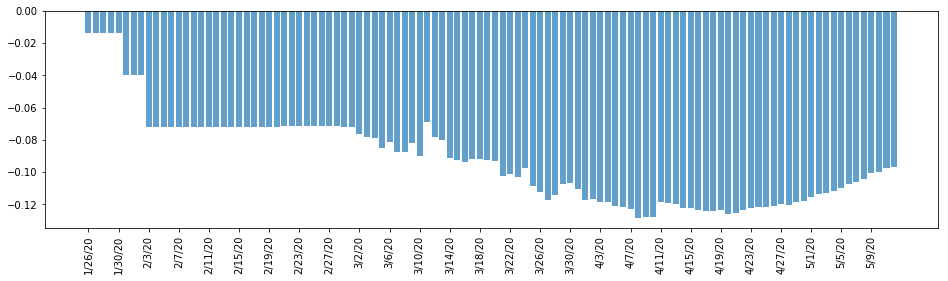

In [79]:
#See which dates most affect the first principal component
#Taken from HW8
def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names[::4], rotation=90);
with plt.rc_context({"figure.figsize": (16, 4)}): 
    plot_pc(list(ca.columns), vt, 0);

### Plot the Counties by the largest two principal components
We can see that there is an outlier, San Benito, and there seems to be two distinct clusters, which we will explore later

In [76]:
fig = px.scatter_3d(data_frame=pc_df, x='pc1', y='pc2', z='pc3', text=list(california_cases['County_x']))
fig.update_traces(textposition='top center')
fig.update_layout(
    height=800,
    title_text='pc1 vs pc2 vs pc3'
)

fig.show()

Visually, we then isolated each cluster, and took the original cases time series data and plotted it to see the differences

In [69]:
temp = california_cases.copy()
#take only the cases by day and normalize based off of the population
temp = temp[dates].div(temp['PopulationEstimate2018'], axis=0)

#cluster0 is the outlier, San Benito, and from eye has pc2 less than 20
cluster0 = temp.iloc[pc_df[pc_df['pc2'] < -20].index]
#cluster1 is the cluster on the left
cluster1 = temp.iloc[pc_df[(pc_df['pc1'] < -10) & (pc_df['pc2'] > -20)].index]
#cluster2 is the group on the right
cluster2 = temp.iloc[pc_df[pc_df['pc1'] > -10].index]
cluster1.head(3)

,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
1,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.001817,0.001817,0.001817,0.001817,0.001817,0.001817,0.001817,0.001817,0.001817,0.001817
18,0.0,0.0,0.0,9.895584e-08,9.895584e-08,9.895584e-08,9.895584e-08,9.895584e-08,9.895584e-08,9.895584e-08,...,0.002543,0.002595,0.002755,0.002837,0.002920,0.003000,0.003091,0.003137,0.003193,0.003286
25,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.001825,0.001825,0.001825,0.001895,0.001965,0.001965,0.002035,0.002035,0.002246,0.002246


The below plot is the beginning of the spread in California, with each county a line, colored by cluster, the first 40 days after 1/23/20. As we can see, the outlier is San Benito in blue, which had a massive per capita spike in infections (or testing).

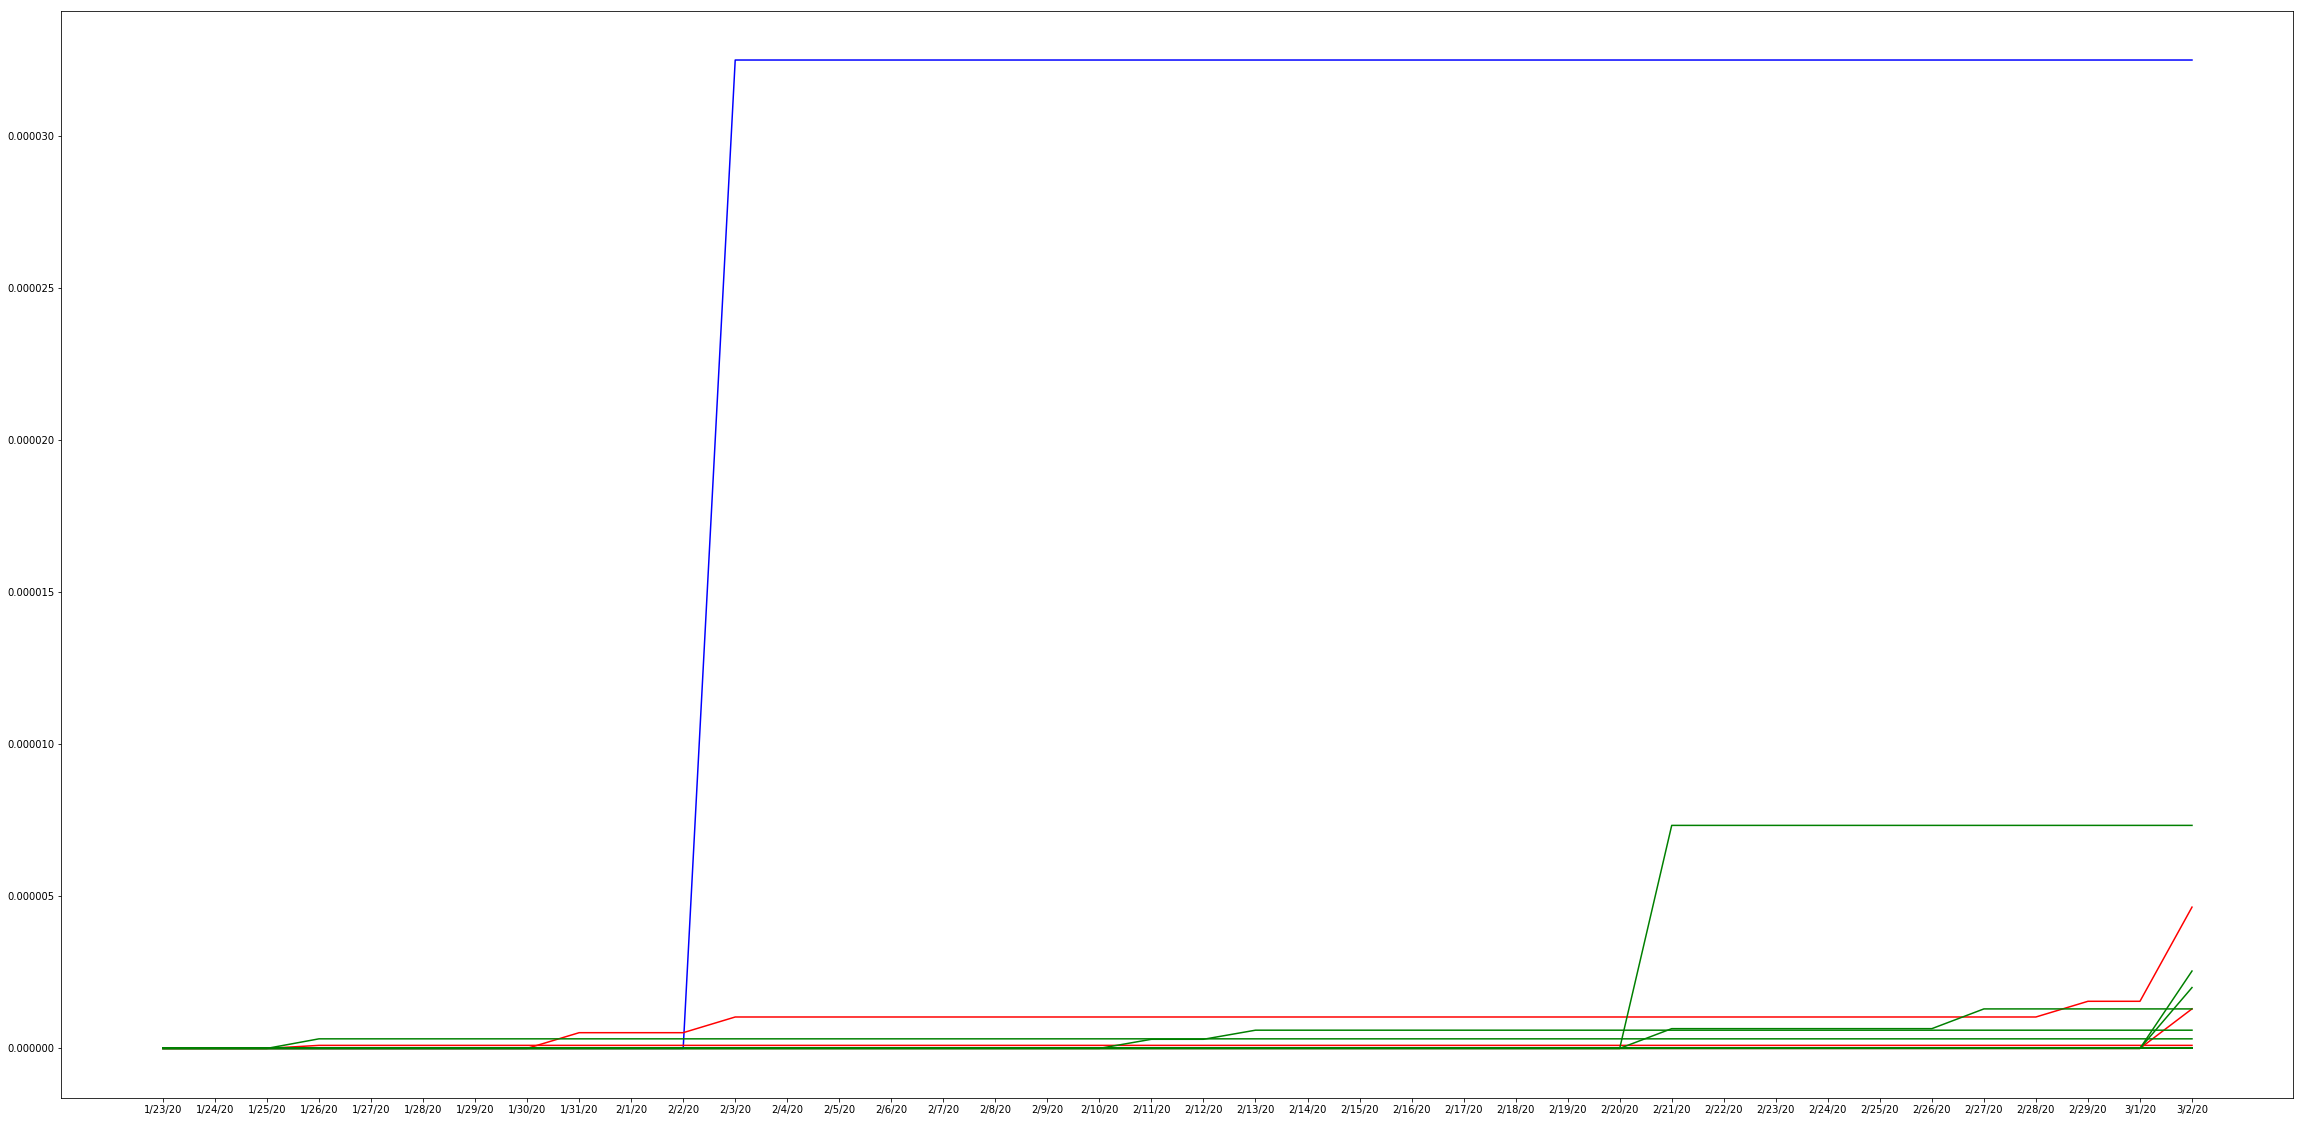

In [70]:
plt.figure(figsize=(40,20))

plt.plot(cluster0.T.drop(cluster1.columns.values[40:]), color='blue')
plt.plot(cluster1.T.drop(cluster1.columns.values[40:]), color='red')
plt.plot(cluster2.T.drop(cluster1.columns.values[40:]), color='green')
plt.show()

The following is the rest of the spread, and it's clear that the red cluster, with smaller pc1 and higher pc2, tends to be more hard hit by the pandemic (especially in the middle). 

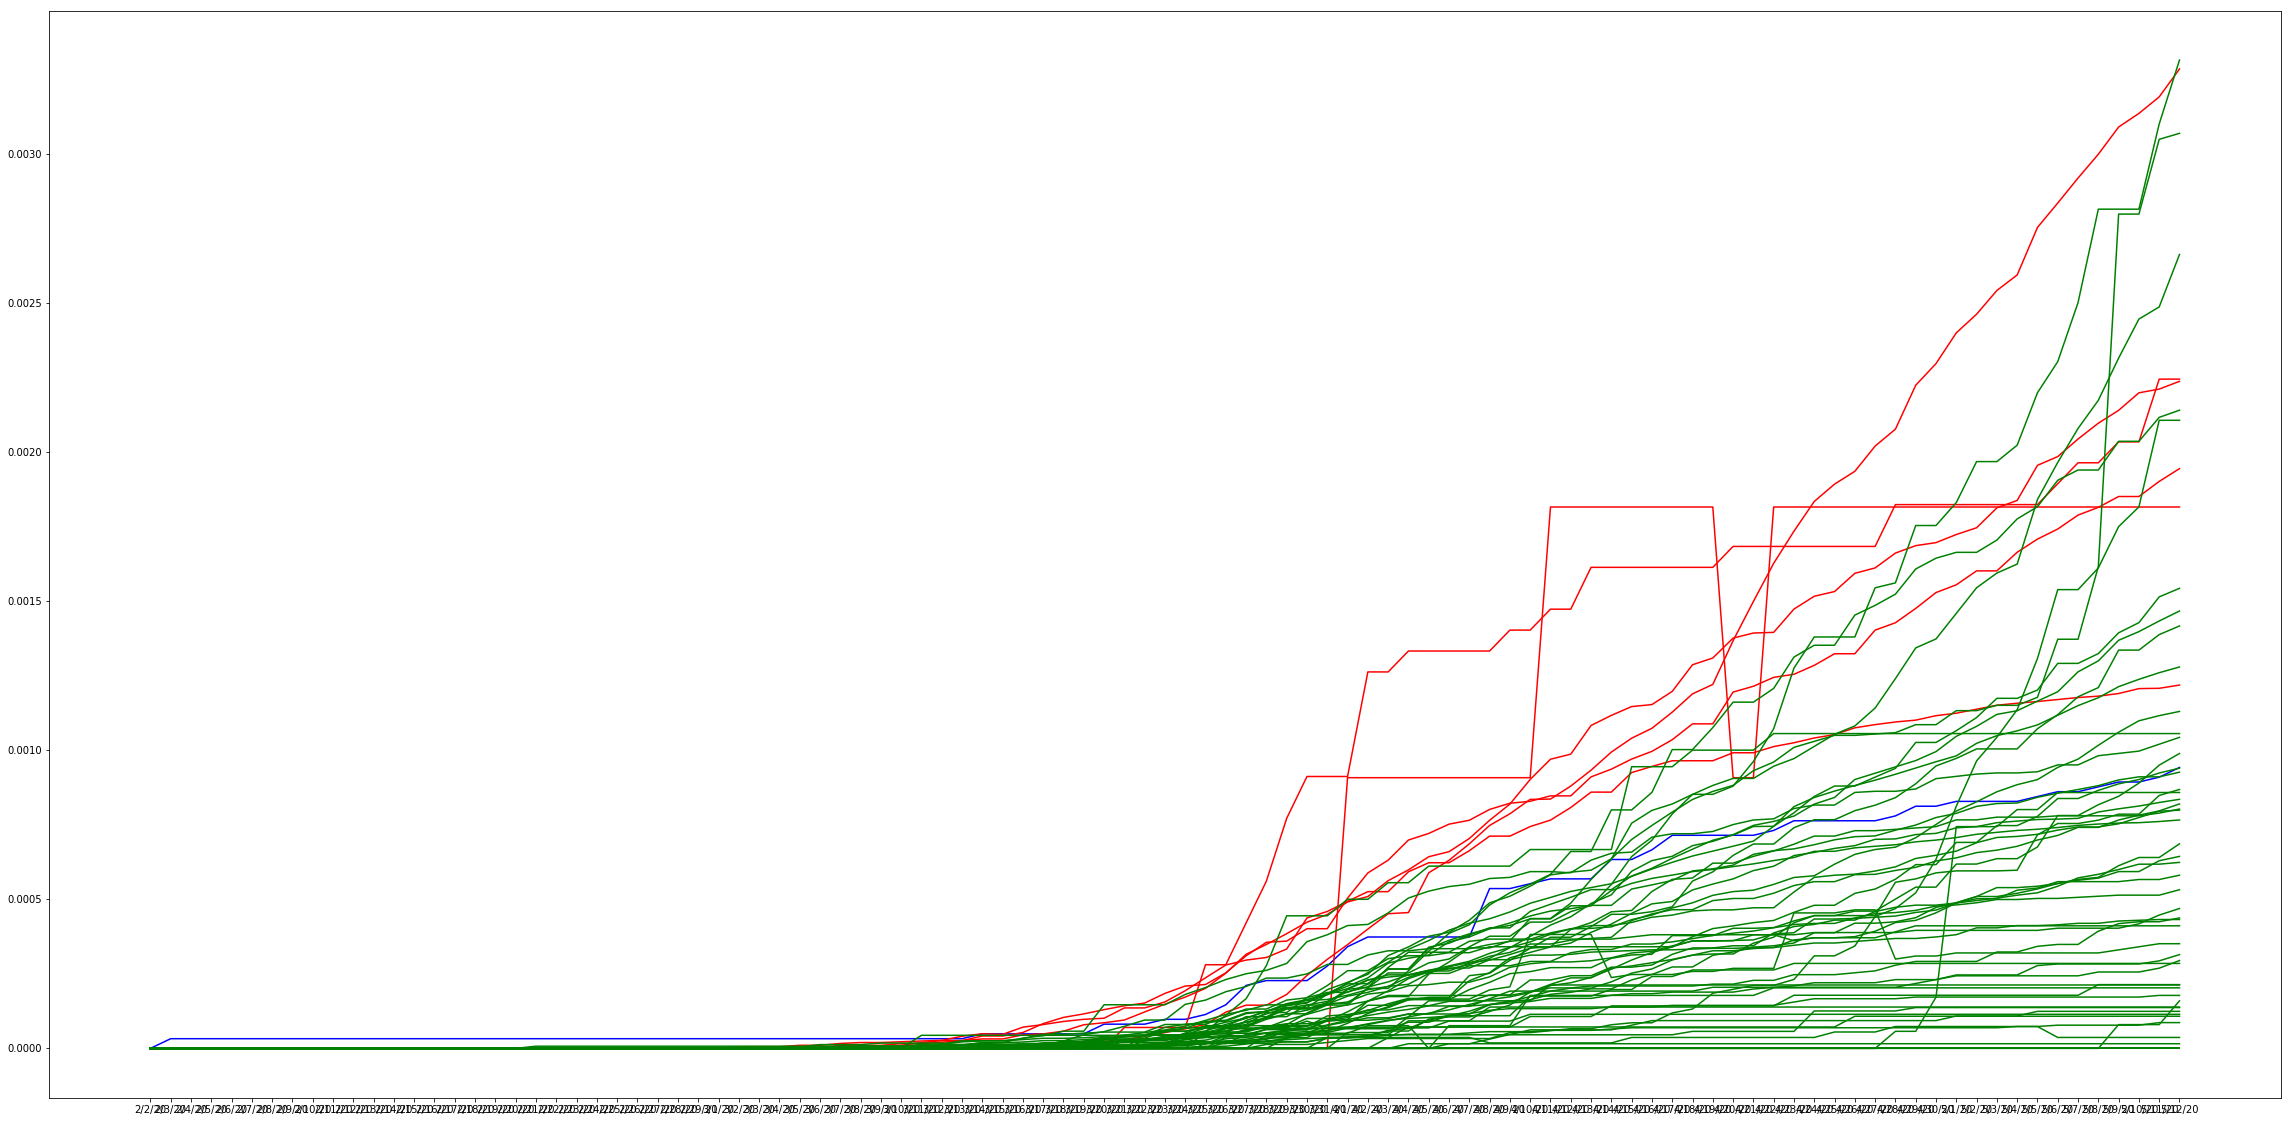

In [73]:
plt.figure(figsize=(40,20))

plt.plot(cluster0.T.drop(cluster1.columns.values[:10]), color='blue')
plt.plot(cluster1.T.drop(cluster1.columns.values[:10]), color='red')
plt.plot(cluster2.T.drop(cluster1.columns.values[:10]), color='green')
plt.show()

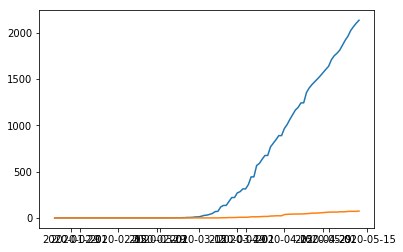

In [66]:
cases.columns.values
dates = cases.columns[11:]
x=pd.to_datetime(dates).values
y=cases[cases['County'] == 'Alameda'][dates].iloc[0].values
sns.lineplot(x=x, y=y)
y=deaths[deaths['County'] == 'Alameda'][dates].iloc[0].values
sns.lineplot(x=x, y=y)